Dataset 
https://www.kaggle.com/yashsawarn/wifi-stretgth-for-rooms?select=train.csv

El objetivo de la Investigacion Corta #3 consiste en elegir un conjunto de datos de baja-mediana complejidad
y aplicarle algunos algoritmos supervisados de su eleccion, de la siguiente forma:


• Una vez definida la ruta de accion a partir de sus datos y el tipo de problema a atacar (predicción o clasificacion), debe aplicar 3 metodos de los vistos en clase, haciendo el analisis completo de los resultados que obtenga y modificando los hiper-parametros de acuerdo a su problema particular. De ser necesario un pre-procesado, debe llevarlo a cabo.

In [120]:
import torch
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sys
np.set_printoptions(threshold=sys.maxsize)


from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Cargar Dataset para analisis de Clasificación

**Descripción del Dataset:** Este dataset consite en clasificar la variable "Room"  (Labels), basado en la intensidad de la señal de distintos routers llamados "A", "B", "C", "D", "E", "F", "G" (Features).  

Importante: Unidad de medición de los features:  (dBm) -> dBmW o decibelio-miliWatt

In [121]:
csv_location = '/content/drive/MyDrive/Colab Notebooks/BSC/Reconocimiento Patrones/INV3/dataset_wifi_stretgth_for_rooms.csv'
data_frame_raw = pd.read_table(csv_location, delimiter = ',' , names=('ID','A', 'B', 'C', 'D','E', 'F', 'G', 'ROOM'),
                       dtype={'ID': np.str,'A': np.int16, 'B': np.int16, 'C': np.int16, 'D': np.int16,'E': np.int16,'F': np.int16,'G': np.int16,'ROOM': np.str})
print("Shape of Dataframe:", data_frame_raw.shape)
data_frame_raw.head(5)

Shape of Dataframe: (1500, 9)


,ID,A,B,C,D,E,F,G,ROOM
0,ID_1,-64,-56,-61,-66,-71,-82,-81,1
1,ID_2,-68,-57,-61,-65,-71,-85,-85,1
2,ID_3,-63,-60,-60,-67,-76,-85,-84,1
3,ID_4,-61,-60,-68,-62,-77,-90,-80,1
4,ID_5,-63,-65,-60,-63,-77,-81,-87,1


# Exploración de Datos

Es importante indicar que la columna ID se refiere unicamente al identificador de la instancia, por lo que no existe una relación entre las columnas ID y ROOM. Por lo tanto vamos a eliminar la columna ID. 

In [122]:
data_frame = data_frame_raw.drop(['ID'], axis=1)
data_frame.head()




,A,B,C,D,E,F,G,ROOM
0,-64,-56,-61,-66,-71,-82,-81,1
1,-68,-57,-61,-65,-71,-85,-85,1
2,-63,-60,-60,-67,-76,-85,-84,1
3,-61,-60,-68,-62,-77,-90,-80,1
4,-63,-65,-60,-63,-77,-81,-87,1


A continuación mostramos varias métricas estadísticas de los features

In [123]:
data_frame.describe()

,A,B,C,D,E,F,G
count,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,-52.319333,-55.95800,-55.319333,-53.800667,-62.905333,-81.188000,-81.973333
std,11.672883,3.37834,5.132666,11.732435,9.127024,6.679002,6.676002
min,-74.000000,-74.00000,-73.000000,-77.000000,-89.000000,-97.000000,-98.000000
25%,-61.000000,-58.00000,-58.250000,-63.000000,-69.000000,-86.000000,-87.000000
50%,-55.000000,-56.00000,-55.000000,-56.000000,-64.000000,-82.000000,-83.000000
75%,-46.000000,-54.00000,-52.000000,-47.000000,-56.000000,-77.000000,-78.000000
max,-10.000000,-46.00000,-40.000000,-11.000000,-36.000000,-61.000000,-63.000000


Averiguamos los valores máximos y mínimos de todas las intensidades de los features, para columnas **A,B,C,D,E,F,G**

In [124]:
minimumIntensity = np.min(data_frame.drop(['ROOM'], axis=1).min())
print("minimumIntensity",minimumIntensity)
maximumIntensity = np.max(data_frame.drop(['ROOM'], axis=1).max())
print("maximumIntensity",maximumIntensity)

minimumIntensity -98
maximumIntensity -10


Histogramas de todos los Attributes (Features) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fdc94ba90>,
      dtype=object)

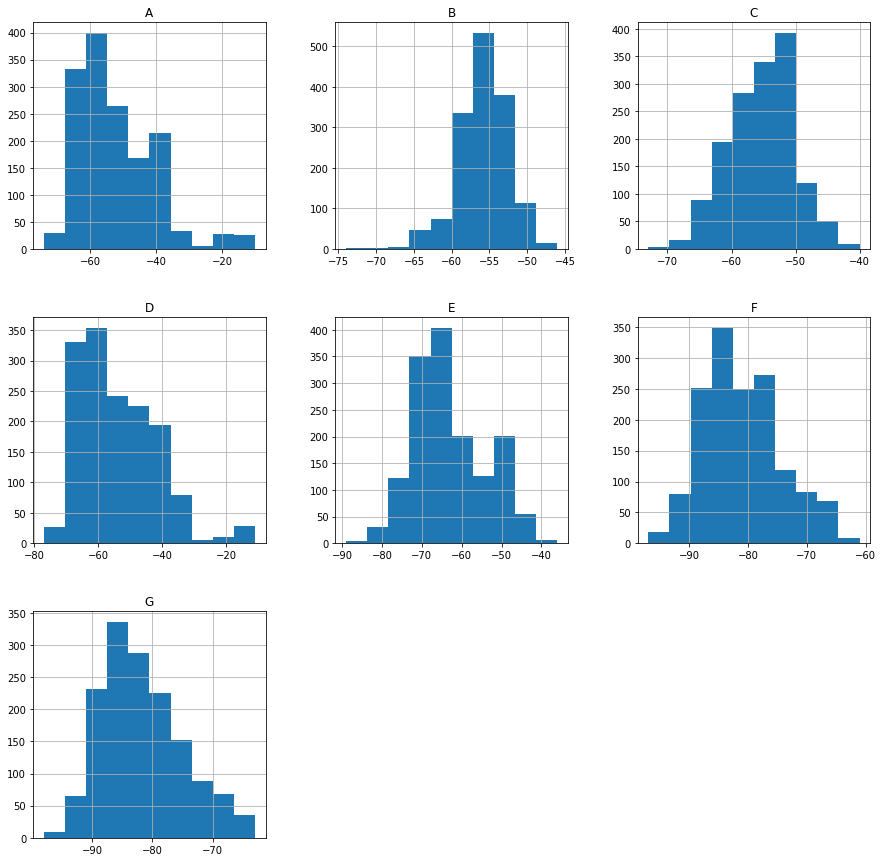

In [125]:
data_frame.hist(figsize = (15,15))

Histogramas de los features traslapados, separado por cada ROOM. Es interesante observar que cada Room tiene features prevalentes los cuales evidencian pistas de cómo se podría clasificar los Rooms. 

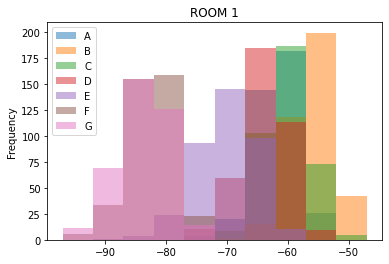

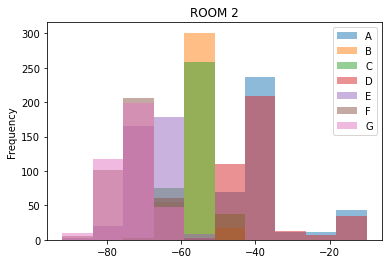

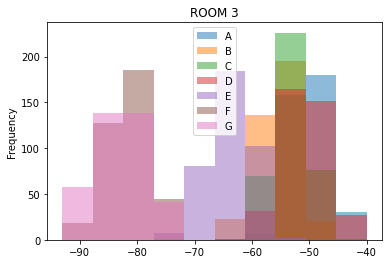

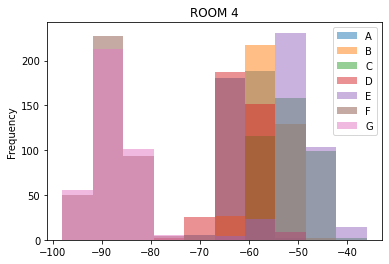

In [126]:
subset1 = data_frame[data_frame["ROOM"]=="1"]
subset1Features = subset1.drop(['ROOM'], axis=1)

subset2 = data_frame[data_frame["ROOM"]=="2"]
subset2Features = subset2.drop(['ROOM'], axis=1)

subset3 = data_frame[data_frame["ROOM"]=="3"]
subset3Features = subset3.drop(['ROOM'], axis=1)

subset4 = data_frame[data_frame["ROOM"]=="4"]
subset4Features = subset4.drop(['ROOM'], axis=1)

subset1Features.plot.hist(alpha = 0.5, title = "ROOM 1")
subset2Features.plot.hist(alpha = 0.5, title = "ROOM 2")
subset3Features.plot.hist(alpha = 0.5, title = "ROOM 3")
subset4Features.plot.hist(alpha = 0.5, title = "ROOM 4")






# Preprocesamiento

Nota* Algunos algoritmos de la libre SKLEARN, si aceptan el dataset en formato One-Hot-Encoding para la clase ROOM. Otros algoritmos aceptan la clase ROOM sin el pre-procesado de One-Hot-Encoding. Por lo que un par de lineas adelante, volvemos a hacer el preprocesado del dataset.

In [127]:
# One Hot Encoding de Etiqueta: ROOM
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
Dataset = data_frame
featuresX = Dataset.drop(["ROOM"], axis=1)
labelsY = Dataset["ROOM"]

encoder = OneHotEncoder(sparse=False)
intermedio = labelsY.to_numpy()

onehotlabelsY = encoder.fit_transform(intermedio.reshape(-1,1))
onehotlabelsY = onehotlabelsY.astype(np.uint8)#Cambiar formato de las etiquetas

X_train, X_test, y_train, y_test = train_test_split(featuresX, onehotlabelsY, test_size=0.2, random_state=17)


# kNN - k Nearest Neighbors

Inicializar listas

In [128]:
training_accuracy = []
test_accuracy = []
iteration = []

Con el objetivo de optimizar el modelo, vamos a iterar el entrenamiento del modelo, basado en la cantidad de Neighbors. 

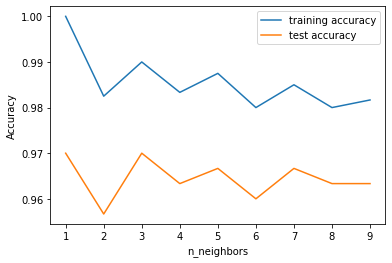

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

neighbors_settings = range(1, 10)# Rango de neighbors a probar
for n_neighbors in neighbors_settings:
    # se construye el modelo de clasificacion
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # se almacena el "training set accuracy"
    training_accuracy.append(clf.score(X_train, y_train))
    # se almacena la "generalization accuracy"
    test_accuracy.append(clf.score(X_test, y_test))
    iteration.append(n_neighbors)
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [130]:
print("training_accuracy",training_accuracy)
print("test_accuracy",test_accuracy)
print("iteration",iteration)

training_accuracy [1.0, 0.9825, 0.99, 0.9833333333333333, 0.9875, 0.98, 0.985, 0.98, 0.9816666666666667]
test_accuracy [0.97, 0.9566666666666667, 0.97, 0.9633333333333334, 0.9666666666666667, 0.96, 0.9666666666666667, 0.9633333333333334, 0.9633333333333334]
iteration [1, 2, 3, 4, 5, 6, 7, 8, 9]


Se observa que un buen escenario de clasificación es cuando n_neighbors=3, ya que ambos Train/Test accuracy son altos, además que es el escenario donde Train Accuracy (0.99) se acerca lo mayor posible a Test Accuracy (0.97).

A continuación se muestra varias predicciones, teniendo como input X_test


In [131]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
print("Compare Results")
y_test_predicted = clf.predict(X_test)
compare = pd.DataFrame(data = np.concatenate((y_test,y_test_predicted),axis=1),columns=['R1_Test','R2_Test','R3_Test','R4_Test','R1_Test_Predict','R2_Test_Predict','R3_Test_Predict','R4_Test_Predict'])
compare.head(10)

Compare Results


,R1_Test,R2_Test,R3_Test,R4_Test,R1_Test_Predict,R2_Test_Predict,R3_Test_Predict,R4_Test_Predict
0,0,0,0,1,0,0,0,1
1,0,1,0,0,0,1,0,0
2,1,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,1
4,0,0,0,1,0,0,0,1
5,0,0,0,1,0,0,0,1
6,0,0,0,1,0,0,0,1
7,1,0,0,0,1,0,0,0
8,0,1,0,0,0,1,0,0
9,0,0,1,0,0,0,1,0


# Decision Trees

Inicializar listas

In [132]:
training_accuracy = []
test_accuracy = []
iteration = []

Con el objetivo de optimizar el modelo, vamos a iterar el entrenamiento del modelo, basado en la profundidad del arbol. 

training_accuracy, test_accuracy [[0.505      0.47333333]
 [0.95166667 0.92666667]
 [0.97       0.94      ]
 [0.9775     0.94      ]
 [0.98916667 0.94666667]
 [0.9875     0.93666667]
 [0.995      0.95333333]
 [0.9975     0.94666667]
 [0.99916667 0.95666667]]


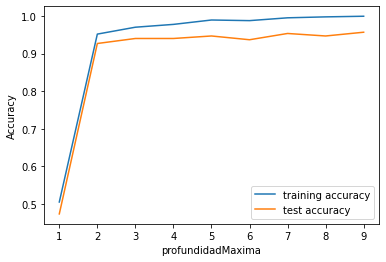

In [133]:
from sklearn import tree
profundidad_settings = range(1, 10)#Probamos distintos niveles del arbol de decision
for profundidadMaxima in profundidad_settings:
    # se construye el modelo de clasificacion
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=profundidadMaxima)
    clf = clf.fit(X_train, y_train)
    # se almacena el "training set accuracy"
    training_accuracy.append(clf.score(X_train, y_train))
    # se almacena la "generalization accuracy"
    test_accuracy.append(clf.score(X_test, y_test))
    iteration.append(profundidadMaxima)

print("training_accuracy, test_accuracy",np.concatenate((np.expand_dims(training_accuracy,1),np.expand_dims(test_accuracy,1)),axis=1))
plt.plot(profundidad_settings, training_accuracy, label="training accuracy")
plt.plot(profundidad_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("profundidadMaxima")
plt.legend()

Observando los valores de accuracy y optimizando el consumo computacional, elegimos profundidadMaxima = 5, con un training_accuracy= 0.98916667  test_accuracy = 0.94666667. 

Además mostramos visualmente la estructura el árbol de decisión. 

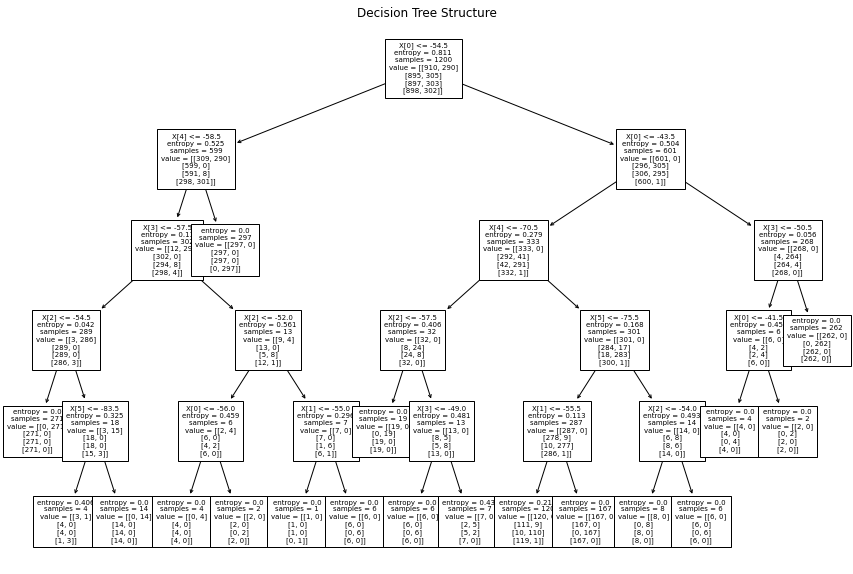

In [134]:
from sklearn import tree

profundidadMaxima = 5
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=profundidadMaxima)
clf = clf.fit(X_train, y_train)

plt.figure(figsize=(15,10))  
tree.plot_tree(clf,fontsize=7)
y_test_predicted = clf.predict(X_test)
plt.title("Decision Tree Structure")
plt.show()




A continuación se muestra varias predicciones, teniendo como input X_test

In [135]:

compare = pd.DataFrame(data = np.concatenate((y_test,y_test_predicted),axis=1),columns=['R1_Test','R2_Test','R3_Test','R4_Test','R1_Test_Predict','R2_Test_Predict','R3_Test_Predict','R4_Test_Predict'])
compare.head(10)

,R1_Test,R2_Test,R3_Test,R4_Test,R1_Test_Predict,R2_Test_Predict,R3_Test_Predict,R4_Test_Predict
0,0,0,0,1,0,0,0,1
1,0,1,0,0,0,1,0,0
2,1,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,1
4,0,0,0,1,0,0,0,1
5,0,0,0,1,0,0,0,1
6,0,0,0,1,0,0,0,1
7,1,0,0,0,1,0,0,0
8,0,1,0,0,0,0,1,0
9,0,0,1,0,0,0,1,0


# Preprocesamiento para Logistic Regression

In [136]:
# El algoritmo no necesita One Hot Encoding
from numpy import asarray
Dataset = data_frame
featuresX = Dataset.drop(["ROOM"], axis=1).to_numpy()
labelsY = Dataset["ROOM"].to_numpy()


X_train, X_test, y_train, y_test = train_test_split(featuresX, labelsY, test_size=0.2, random_state=17)

# Logistic Regression Multiclass

Iniciamos listas

In [137]:
training_accuracy = []
test_accuracy = []
iteration = []

Entrenamos el modelo 

In [138]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver = "newton-cg")# Multiclass hyperparameter solver = "newton-cg"
clf.fit(X_train, y_train)

print("Accuracy Train", clf.score(X_train, y_train))
print("Accuracy Test", clf.score(X_test, y_test))
y_test_predicted = clf.predict(X_test)





Accuracy Train 0.9875
Accuracy Test 0.9766666666666667


A continuación se muestra varias predicciones, teniendo como input X_test

In [139]:
y_test = pd.DataFrame(y_test)
y_test_predicted = pd.DataFrame(y_test_predicted)
compare = pd.DataFrame(data = np.concatenate((y_test,y_test_predicted),axis=1),columns=['Room y_test','Room y_test_predicted'])
compare.head(10)

,Room y_test,Room y_test_predicted
0,4,4
1,2,2
2,1,1
3,4,4
4,4,4
5,4,4
6,4,4
7,1,1
8,2,3
9,3,3


# Metodos de ensamble (Ensemble learning)

**• Explique en que consisten los metodos de ensamble y cuales son sus principales caracterısticas.**

Los métodos de ensamble ayudan a mejorar los resultados del aprendizaje automático mediante la combinación de varios modelos base. Este enfoque permite la producción de un mejor rendimiento predictivo en comparación con un solo modelo. 

Los métodos de conjunto son algoritmos que combinan varias técnicas de aprendizaje automático en un modelo predictivo para disminuir la varianza (bagging), el sesgo (boosting) o mejorar las predicciones (stacking).

Los métodos de conjunto se pueden dividir en dos grupos:

->**Métodos de conjunto secuencial** donde los algoritmos base se generan secuencialmente. La motivación básica de los métodos secuenciales es explotar la dependencia entre los algoritmos de base.

->**Métodos de conjuntos paralelos** donde los algoritmos base se generan en paralelo. La motivación básica de los métodos paralelos es aprovechar la independencia entre los algoritmos de base, ya que el error se puede reducir drásticamente promediando.

La mayoría de los métodos de conjunto utilizan un algoritmo de aprendizaje de base única para producir algoritmos de base **homogéneos**, es decir, algoritmos del mismo tipo, que conducen a conjuntos homogéneos. También hay algunos métodos que utilizan algoritmos **heterogéneos**, es decir, algoritmos de diferentes tipos, lo que conduce a conjuntos heterogéneos. 


-> Tomado de: https://blog.statsbot.co/ensemble-learning-d1dcd548e936






**• Ejecutar el mismo analisis anterior pero esta vez para un metodo de ensamble que no se haya visto en clase.**

Utilizaremos el algoritmo de ensamble llamado GradientBoosting. 

Descripción breve tomada de https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html:


Gradient Boosting construye un modelo aditivo de manera progresiva por etapas; permite la optimización de funciones de pérdida diferenciables arbitrarias. En cada etapa, varios Regression Trees se ajustan al gradiente negativo de la función de pérdida de desviación binomial o multinomial.


In [140]:
training_accuracy = []
test_accuracy = []
iteration = []

In [141]:
# El algoritmo no necesita One Hot Encoding
from numpy import asarray
Dataset = data_frame
featuresX = Dataset.drop(["ROOM"], axis=1).to_numpy()
labelsY = Dataset["ROOM"].to_numpy()


X_train, X_test, y_train, y_test = train_test_split(featuresX, labelsY, test_size=0.2, random_state=17)

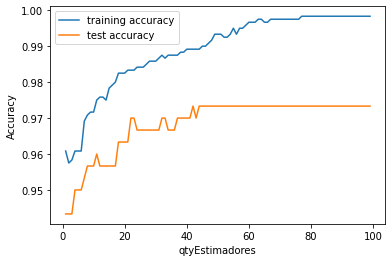

In [142]:
from sklearn.ensemble import GradientBoostingClassifier
estimators_settings = range(1, 100)#Probamos distintos niveles del arbol de decision
for qtyEstimadores in estimators_settings:
    # se construye el modelo de clasificacion
    clf = GradientBoostingClassifier(n_estimators=qtyEstimadores, learning_rate=0.1, max_depth=2, random_state=0)
    clf = clf.fit(X_train, y_train)
    # se almacena el "training set accuracy"
    training_accuracy.append(clf.score(X_train, y_train))
    # se almacena la "generalization accuracy"
    test_accuracy.append(clf.score(X_test, y_test))    
    iteration.append(qtyEstimadores)

#print("training_accuracy, test_accuracy",np.concatenate((np.expand_dims(training_accuracy,1),np.expand_dims(test_accuracy,1)),axis=1))
plt.plot(estimators_settings, training_accuracy, label="training accuracy")
plt.plot(estimators_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("qtyEstimadores")
plt.legend()

Se observa en la gráfica que para qtyEstimators = 40, obtenemos bueno valores de accuracy para Test (>.97) y Train (≈.99). Por lo que utilizaremos qtyEstimators = 40. 

In [143]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=40, learning_rate=0.1, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_test_predicted = clf.predict(X_test)

y_test = pd.DataFrame(y_test)
y_test_predicted = pd.DataFrame(y_test_predicted)


A continuación se muestra varias predicciones, teniendo como input X_test

In [144]:
compare = pd.DataFrame(data = np.concatenate((y_test,y_test_predicted),axis=1),columns=['Room y_test','Room y_test_predicted'])
compare.head(10)


,Room y_test,Room y_test_predicted
0,4,4
1,2,2
2,1,1
3,4,4
4,4,4
5,4,4
6,4,4
7,1,1
8,2,3
9,3,3
